In [17]:
import pandas as pd
import numpy as np
import json
import os
from multiprocessing import Pool
from tqdm.notebook import tqdm
import gc
import pickle
import joblib
import cv2
#import bz2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [11]:
import os
data_path = 'data/imaterialist-fashion-2020-fgvc7'
os.listdir(data_path)

['label_descriptions.json',
 'sample_submission.csv',
 'test',
 'train',
 'train.csv']

In [12]:
train_df = pd.read_csv(data_path+'/train.csv')

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333401 entries, 0 to 333400
Data columns (total 6 columns):
ImageId          333401 non-null object
EncodedPixels    333401 non-null object
Height           333401 non-null int64
Width            333401 non-null int64
ClassId          333401 non-null int64
AttributesIds    206410 non-null object
dtypes: int64(3), object(3)
memory usage: 15.3+ MB


In [21]:
encoded_pixels = train_df[train_df['ImageId']=='00000663ed1ff0c4e0132b9b9ac53f6e']['EncodedPixels']
class_ids = train_df[train_df['ImageId']=='00000663ed1ff0c4e0132b9b9ac53f6e']['ClassId']

In [46]:
for indice, (encoded_pixel_str, class_id) in enumerate(zip(encoded_pixels, class_ids)):
    splitted_pixels = list(map(int, encoded_pixel_str.split()))
    pixel_starts = splitted_pixels[::2]

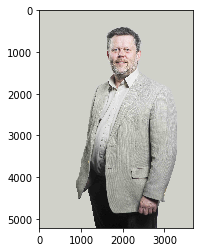

In [55]:
plt.imshow(create_mask('00000663ed1ff0c4e0132b9b9ac53f6e', train_df, data_path+'/train/')[0])

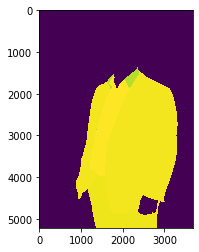

In [57]:
plt.imshow(create_mask('00000663ed1ff0c4e0132b9b9ac53f6e', train_df, data_path+'/train/')[1])

In [56]:
def create_mask(image_id, df, img_dir_path):
    
    img = mpimg.imread(img_dir_path+image_id+'.jpg')
    encoded_pixels = df[df['ImageId']==image_id]['EncodedPixels']
    class_ids = df[df['ImageId']==image_id]['ClassId']
    height, width = img.shape[:2]
    
    mask = np.zeros((height, width)).reshape(-1)
    for indice, (encoded_pixel_str, class_id) in enumerate(zip(encoded_pixels, class_ids)):
        splitted_pixels = list(map(int, encoded_pixel_str.split()))
        start_indices = splitted_pixels[::2]
        indice_lengths = splitted_pixels[1::2]
        for start_indice, indice_length in zip(start_indices, indice_lengths):
            start_indice-=1
            mask[start_indice:start_indice+indice_length] = 255 - class_id
    return img, mask.reshape((height, width), order='F')
    

In [53]:
create_mask('00000663ed1ff0c4e0132b9b9ac53f6e', train_df, data_path+'/train/')[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
def create_mask(size):
    image_ids = train_df['ImageId'].unique()[:size]
    images_meta=[]

    for image_id in image_ids:
        img = mpimg.imread(f'/kaggle/input/imaterialist-fashion-2020-fgvc7/train/{image_id}.jpg')
        images_meta.append({
            'image': img,
            'shape': img.shape,
            'encoded_pixels': train_df[train_df['ImageId'] == image_id]['EncodedPixels'],
            'class_ids':  train_df[train_df['ImageId'] == image_id]['ClassId']
        })

    masks = []
    for image in images_meta:
        shape = image.get('shape')
        encoded_pixels = list(image.get('encoded_pixels'))
        class_ids = list(image.get('class_ids'))
        
        # Initialize numpy array with shape same as image size
        height, width = shape[:2]
        mask = np.zeros((height, width)).reshape(-1)
        
        # Iterate over encoded pixels and create mask
        for segment, (pixel_str, class_id) in enumerate(zip(encoded_pixels, class_ids)):
            splitted_pixels = list(map(int, pixel_str.split()))
            pixel_starts = splitted_pixels[::2]
            run_lengths = splitted_pixels[1::2]
            assert max(pixel_starts) < mask.shape[0]
            for pixel_start, run_length in zip(pixel_starts, run_lengths):
                pixel_start = int(pixel_start) - 1
                run_length = int(run_length)
                mask[pixel_start:pixel_start+run_length] = 255 - class_id * 4
        masks.append(mask.reshape((height, width), order='F'))  # https://stackoverflow.com/questions/45973722/how-does-numpy-reshape-with-order-f-work
    return masks, images_meta

'6068157 7 6073371 20 6078584 34 6083797 48 6089010 62 6094223 72 6099436 76 6104649 80 6109862 85 6115075 89 6120288 93 6125501 98 6130714 102 6135927 106 6141140 111 6146354 114 6151567 118 6156780 123 6161993 127 6167206 131 6172419 136 6177632 140 6182845 144 6188058 149 6193271 153 6198484 157 6203697 162 6208910 166 6214124 169 6219337 174 6224550 178 6229763 182 6234976 187 6240189 191 6245402 195 6250615 200 6255828 204 6261041 208 6266254 213 6271467 218 6276680 224 6281893 229 6287107 233 6292320 238 6297533 244 6302746 249 6307959 254 6313172 259 6318385 265 6323598 270 6328811 275 6334024 280 6339237 286 6344450 291 6349663 296 6354877 300 6360090 306 6365303 311 6370516 316 6375729 322 6380942 327 6386155 332 6391368 337 6396581 343 6401794 348 6407007 353 6412220 358 6417433 364 6422647 368 6427860 373 6433073 378 6438286 384 6443499 389 6448712 394 6453925 399 6459138 405 6464351 410 6469564 415 6474777 420 6479990 426 6485203 431 6490416 436 6495630 441 6500843 446 6506

In [ ]:
cv2.im_re